# Configure SBS Parameters

This notebook should be used as a test for ensuring correct SBS image loading and processing before running the SBS module.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for SBS processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
from pathlib import Path

import yaml
from tifffile import imread
import pandas as pd
from snakemake.io import expand
from microfilm.microplot import Microimage
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_micropanel,
    random_cmap,
    image_segmentation_annotations,
)
from lib.shared.file_utils import get_filename
from lib.sbs.align_cycles import align_cycles
from lib.shared.log_filter import log_filter
from lib.sbs.compute_standard_deviation import compute_standard_deviation
from lib.sbs.max_filter import max_filter
from lib.sbs.find_peaks import find_peaks, find_peaks_spotiflow, plot_channels_with_peaks
from lib.shared.illumination_correction import apply_ic_field, combine_ic_images
from lib.shared.segment_cellpose import (
    prepare_cellpose,
    estimate_diameters,
    segment_cellpose,
)
from lib.shared.segment_microsam import segment_microsam
from lib.shared.segment_stardist import segment_stardist
from lib.shared.segment_watershed import segment_watershed
from lib.sbs.extract_bases import extract_bases
from lib.sbs.call_reads import call_reads
from lib.sbs.call_cells import call_cells
from lib.shared.extract_phenotype_minimal import extract_phenotype_minimal
from lib.sbs.eval_mapping import (
    plot_mapping_vs_threshold,
    plot_cell_mapping_heatmap,
    plot_reads_per_cell_histogram,
    plot_gene_symbol_histogram,
)

2025-05-01 12:41:52.768347: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## <font color='red'>SET PARAMETERS</font>

### Parameters for testing SBS processing

- `TEST_PLATE`, `TEST_WELL`, `TEST_TILE`: Plate/well/tile combination used for configuring parameters in this notebook.

### Channels

- `CHANNEL_NAMES`: A list of names for each channel in your SBS image. Should include one channel for DAPI and other channels for bases.
- `CHANNEL_CMAPS`: A list of color maps to use when showing channel microimages. These need to be a Matplotlib or microfilm colormap. We recommend using: `["pure_red", "pure_green", "pure_blue", "pure_cyan", "pure_magenta", "pure_yellow"]`.

In [3]:
# Define test well and tile
TEST_PLATE = 1
TEST_WELL = "B2"
TEST_TILE = 50
# Derive wildcard dictionary for testing
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

# Define image channels with DAPI as the first channel
CHANNEL_NAMES = ["DAPI", "G", "T", "A", "C"]
CHANNEL_CMAPS = ["pure_blue", "pure_green", "pure_red", "pure_cyan", "pure_magenta"]

# Remove DAPI channel to get bases
BASES = CHANNEL_NAMES[1:]

## <font color='red'>SET PARAMETERS</font>

### Alignment

- `ALIGNMENT_METHOD`: Methodology for aligning SBS images. Alignment happens automatically within a cycle. Alignment between cycles can occur in one of two ways: 
    - `DAPI`: the DAPI intensity is aligned between cycles. This is recommended if a nuclear stain is captured for **each** round of SBS imaging.
    - `sbs_mean`: the mean intensity is aligned between cycles. This is recommended if a nuclear stain is captured only in the first round of SBS imaging. 
- `KEEP_EXTRAS`: Whether to keep extra channels (that are not imaged in each round) when aligning. Defaults to `FALSE`
    - Set to `FALSE` if a nuclear stain is captured for **each** round of SBS imaging.
    - Set to `TRUE` if a nuclear stain is captured only in the first round of SBS imaging. 
- `UPSAMPLE_FACTOR`: Factor used for subpixel alignment. Defaults to `2`
    - Higher values provide more precise alignment but increase processing time.
    - Set to `1` to disable subpixel alignment for faster processing.

In [4]:
ALIGNMENT_METHOD = "DAPI"
KEEP_EXTRAS = False
UPSAMPLE_FACTOR = 2

Loading test images...
Aligning test images...
Example aligned image for first cycle:


microplot.py (725): Ignoring specified arguments in this call because figure with num: 1 already exists


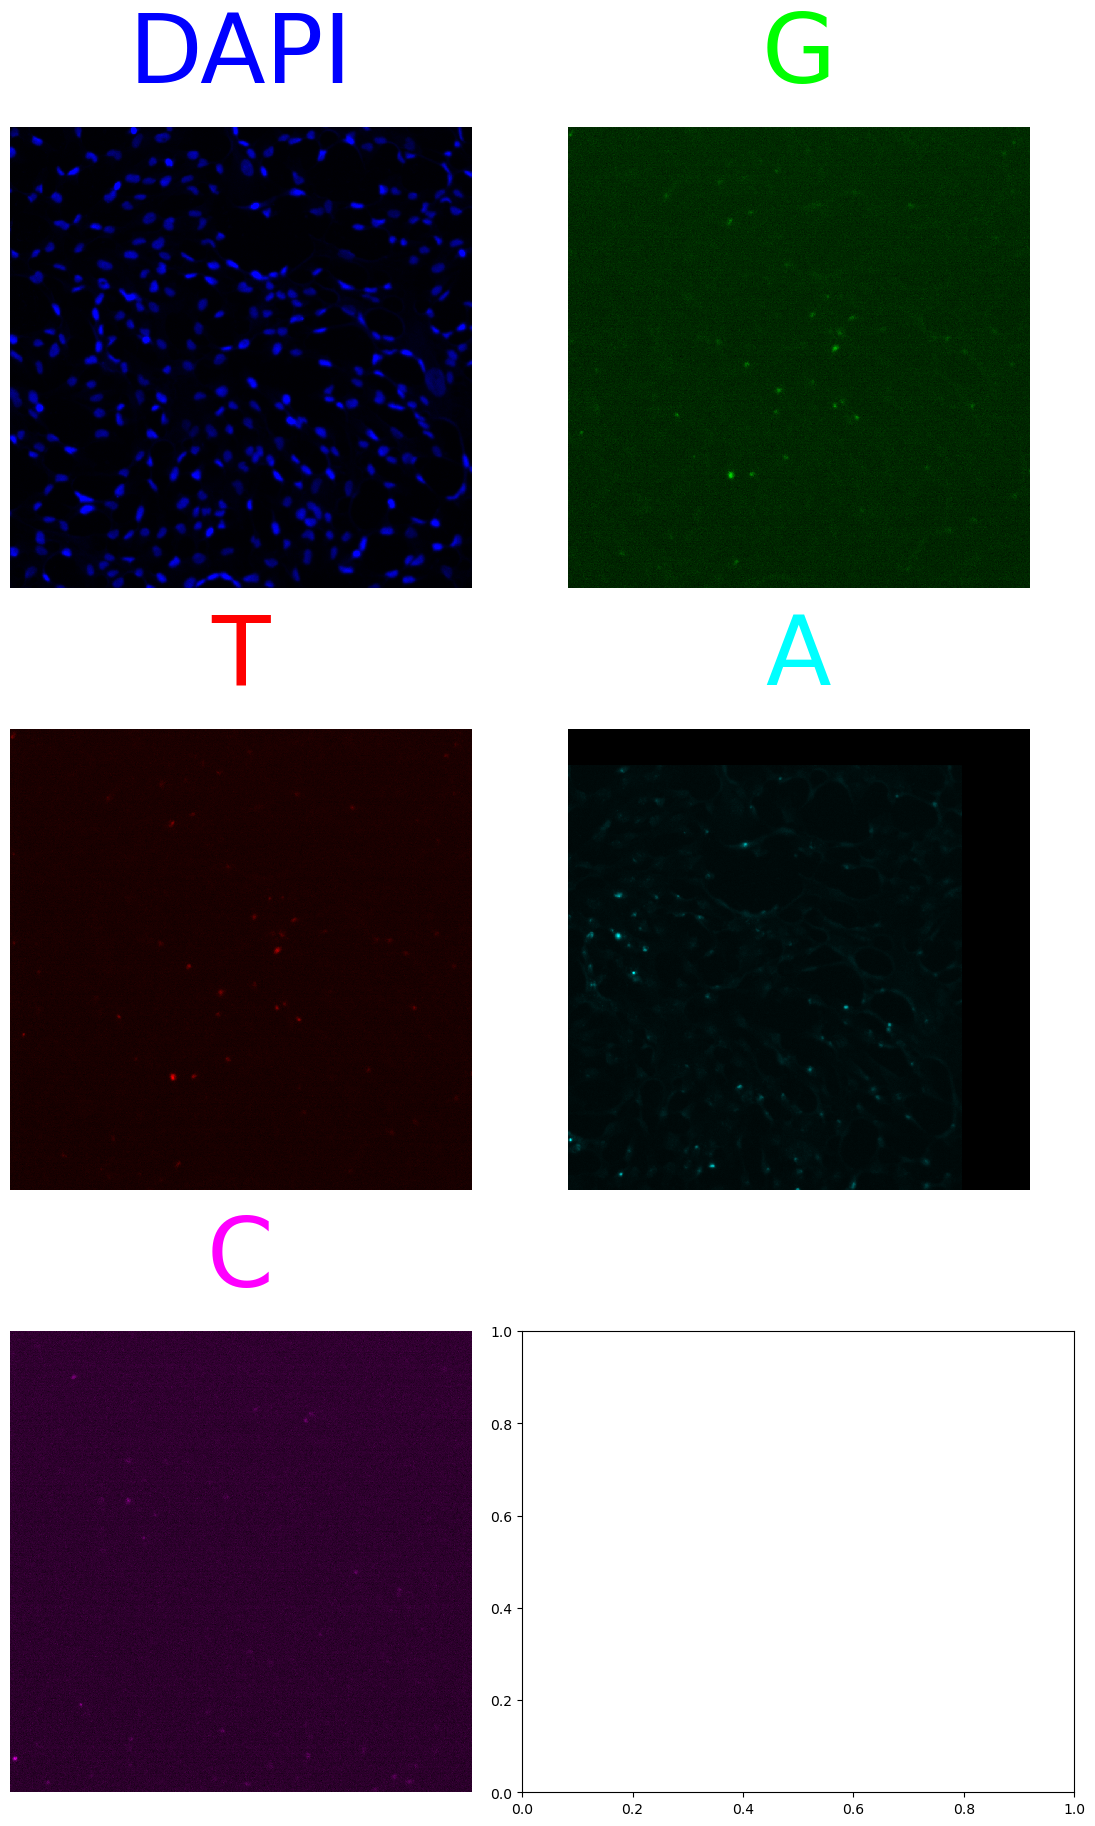

In [7]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# Get paths to the sample files dfs
SBS_SAMPLES_FP = Path(config["preprocess"]["sbs_samples_fp"])
# Load the sample TSV files with pandas
sbs_samples = pd.read_csv(SBS_SAMPLES_FP, sep="\t")
SBS_CYCLES = sorted(list(sbs_samples["cycle"].unique()))

# load test image data
print("Loading test images...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
sbs_test_image_paths = expand(
    PREPROCESS_FP
    / "images"
    / "sbs"
    / get_filename(
        {"plate": TEST_PLATE, "well": TEST_WELL, "tile": TEST_TILE, "cycle": "{cycle}"},
        "image",
        "tiff",
    ),
    cycle=SBS_CYCLES,
)
sbs_test_images = [imread(file_path) for file_path in sbs_test_image_paths]


# align cycles
print("Aligning test images...")
aligned = align_cycles(
    sbs_test_images,
    method=ALIGNMENT_METHOD,
    upsample_factor=1,
    keep_extras=KEEP_EXTRAS,
)

# Create and display micropanel of aligned images
print("Example aligned image for first cycle:")
aligned_microimages = [
    Microimage(
        aligned[0, i, :, :], channel_names=CHANNEL_NAMES[i], cmaps=CHANNEL_CMAPS[i]
    )
    for i in range(aligned.shape[1])
]
aligned_panel = create_micropanel(aligned_microimages, add_channel_label=True)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Spot detection

- `MAX_FILTER_WIDTH`: Width parameter used for determining the neighborhood size for finding local maxima. No default value, but `3` is suggested
- `SPOT_DETECTION_METHOD`: Methodology for calling spots: 
    - `STANDARD`: Standard method for calling spots, involving Laplacian of Gaussian correction, and computation of spots across cycles. Spots are identified based on signal intensity and consistency across cycles.
        - `PEAK_WIDTH`: Width parameter used for peak detection, sets neighborhood size for finding local maxima of base channels standard deviation. Defaults to `5`
    - `SPOTIFLOW`: Deep learning based methodology for calling spots. Spots are called independently on all 4 bases of a selected cycle, and then coalesced to ensure minimum distance between spots. If this method is selected, the following parameters are required:
        - `SPOTIFLOW_CYCLE_INDEX`: Cycle to use for spot detection
        - `SPOTIFLOW_MODEL`: Model to use for spot detection (e.g., "general", "hybiss")
        - `SPOTIFLOW_THRESHOLD`: Probability threshold for confidence in spot detection
        - `SPOTIFLOW_MIN_DISTANCE`: Minimum distance (in pixels) required between detected spots


In [8]:
# Set parameters:
MAX_FILTER_WIDTH = 3
SPOT_DETECTION_METHOD = "standard"

if SPOT_DETECTION_METHOD == "standard":
   PEAK_WIDTH = 5

elif SPOT_DETECTION_METHOD == "spotiflow":
   SPOTIFLOW_CYCLE_INDEX = 0
   SPOTIFLOW_MODEL = "general"
   SPOTIFLOW_THRESHOLD = 0.3         
   SPOTIFLOW_MIN_DISTANCE = 1

Detecting candidate reads...
Applying Laplacian-of-Gaussian (LoG) filter...
Applying max filter...
Computing standard deviation over cycles...
Finding peaks using standard method...
Example max filtered image for first cycle:


microplot.py (725): Ignoring specified arguments in this call because figure with num: 1 already exists


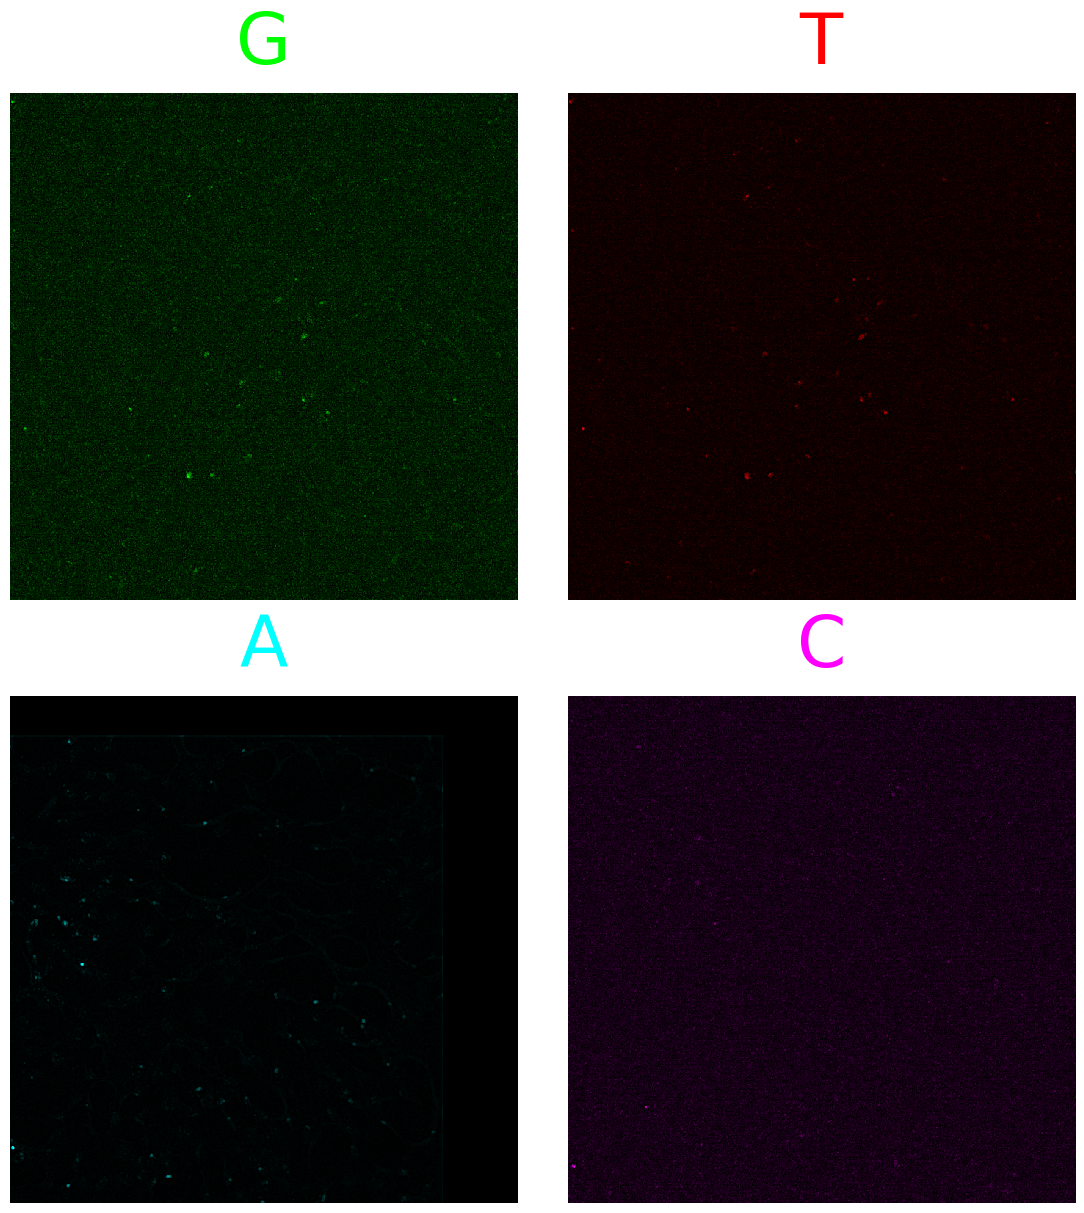

Found 0 peaks above threshold 300


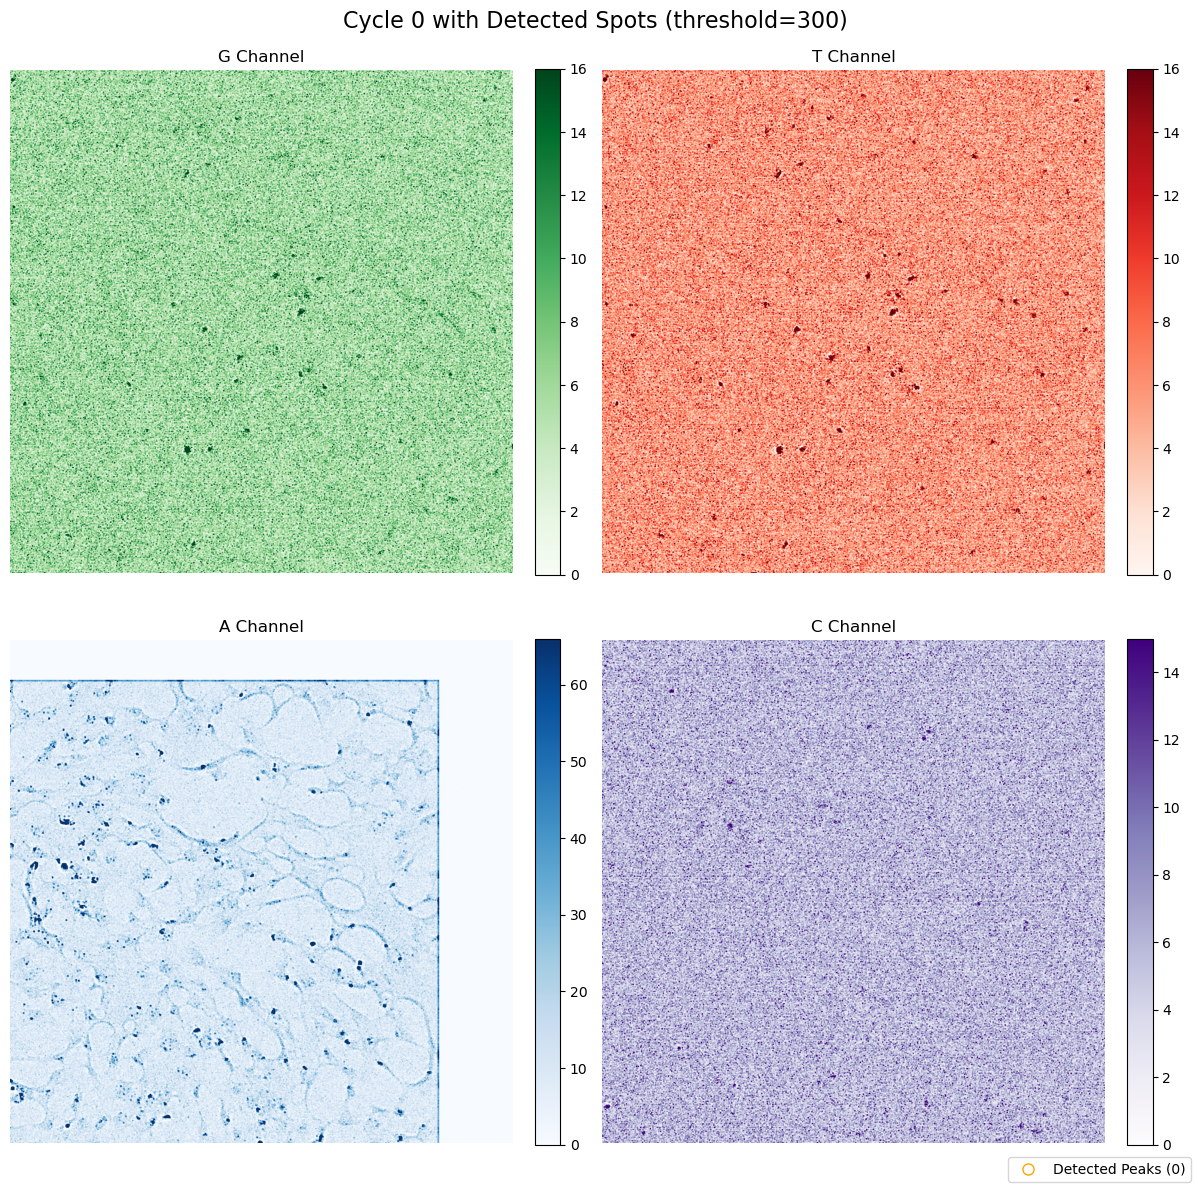

In [9]:
print("Detecting candidate reads...")

print("Applying Laplacian-of-Gaussian (LoG) filter...")
loged = log_filter(aligned, skip_index=0)

print("Applying max filter...")
maxed = max_filter(loged, width=MAX_FILTER_WIDTH, remove_index=0)

if SPOT_DETECTION_METHOD == "standard":
    print("Computing standard deviation over cycles...")
    standard_deviation = compute_standard_deviation(loged, remove_index=0)
    
    print("Finding peaks using standard method...")
    peaks = find_peaks(standard_deviation, width=PEAK_WIDTH)
    
elif SPOT_DETECTION_METHOD == "spotiflow":
    print(f"Finding peaks using Spotiflow (model: {SPOTIFLOW_MODEL})...")
    peaks, _ = find_peaks_spotiflow(
        aligned_images=aligned, 
        cycle_idx=SPOTIFLOW_CYCLE_INDEX,
        model=SPOTIFLOW_MODEL,
        prob_thresh=SPOTIFLOW_THRESHOLD,
        min_distance=SPOTIFLOW_MIN_DISTANCE,
        verbose=True
    )

# Create and display micropanel of max filtered datas
print("Example max filtered image for first cycle:")
maxed_microimages = [
    Microimage(maxed[0, i, :, :], channel_names=BASES[i], cmaps=CHANNEL_CMAPS[i + 1])
    for i in range(maxed.shape[1])
]
maxed_panel = create_micropanel(maxed_microimages, add_channel_label=True)
plt.show()

# Plot spots on base channels
fig, axes = plot_channels_with_peaks(
    maxed,                 
    peaks,
    BASES,        
    cycle_number=0,   
    threshold_peaks=300 if SPOT_DETECTION_METHOD == "standard" else None,
    peak_colors=['orange'],
    peak_labels=['Detected Peaks']
)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Illumination correction and Segmentation

- `SEGMENTATION_CYCLE`: Index of cycle used for illumination correction and segmentation. Typically, this is set to the cycle with the brightest or clearest signal for cell boundaries (there is often the most background signal in the last cycle, so that is often used).
- `CYTO_CHANNEL`: The name of the cytoplasmic channel in your image stack. Typically the channel that best outlines cell boundaries, usually base C.

In [10]:
# Define cycle to use for segmentation, -1 for last cycle
SEGMENTATION_CYCLE = 1
# Define cytoplasmic channel
CYTO_CHANNEL = "C"

# Derive DAPI and CYTO indexes
SEGMENTATION_CYCLE_INDEX = SBS_CYCLES.index(SEGMENTATION_CYCLE)
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)

Applying illumination correction to segmentation cycle image...


Preparing IC segmentation image for CellPose...


dtype.py (576): Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8


Pre-segmentation images:


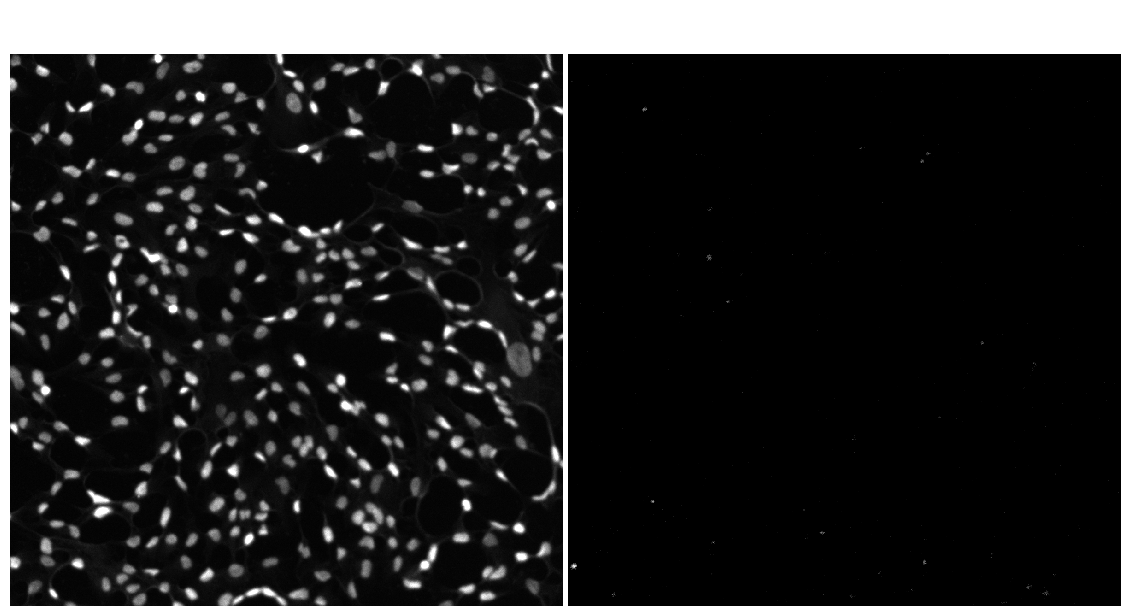

In [11]:
# Determine the cycle to use for segmentation
sbs_segmentation_cycle = SBS_CYCLES[SEGMENTATION_CYCLE_INDEX]
aligned_image_data_segmentation_cycle = aligned[SEGMENTATION_CYCLE_INDEX]

print("Applying illumination correction to segmentation cycle image...")
# Read the illumination correction file
if KEEP_EXTRAS:
    ic_field_dapi = imread(
        PREPROCESS_FP
        / "ic_fields"
        / "sbs"
        / get_filename(
            {"plate": TEST_PLATE, "well": TEST_WELL, "cycle": 1}, "ic_field", "tiff"
        )
    )
    ic_field_full = imread(
        PREPROCESS_FP
        / "ic_fields"
        / "sbs"
        / get_filename(
            {"plate": TEST_PLATE, "well": TEST_WELL, "cycle": sbs_segmentation_cycle},
            "ic_field",
            "tiff",
        )
    )
    ic_field = combine_ic_images([ic_field_dapi, ic_field_full], [DAPI_INDEX, None])
else:
    ic_field = imread(
        PREPROCESS_FP
        / "ic_fields"
        / "sbs"
        / get_filename(
            {"plate": TEST_PLATE, "well": TEST_WELL, "cycle": sbs_segmentation_cycle},
            "ic_field",
            "tiff",
        )
    )

# Apply illumination correction field
corrected_image = apply_ic_field(
    aligned_image_data_segmentation_cycle, correction=ic_field
)

# Prepare corrected image for CellPose segmentation
# NOTE: this process is done during the `segment_cellpose`` method below as well
# Use the prepared_cellpose image to test CellPose (see below)
print("Preparing IC segmentation image for CellPose...")
cellpose_rgb = prepare_cellpose(
    corrected_image,
    DAPI_INDEX,
    CYTO_INDEX,
)

# show max filtered data for one round
print("Pre-segmentation images:")
pre_seg_microimages = [
    Microimage(cellpose_rgb[2], channel_names="Dapi"),
    Microimage(cellpose_rgb[1], channel_names="Cyto"),
]
pre_seg_panel = create_micropanel(pre_seg_microimages, add_channel_label=True)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Segmentation

#### Select Segmentation Method
- `SEGMENTATION_METHOD`: Choose from "cellpose", "microsam", "stardist", or "watershed" for cell segmentation.

#### Common Parameters
- `GPU`: Set to True to use GPU acceleration (if available).
- `RECONCILE`: Method for reconciling nuclei and cell masks (typically "contained_in_cells", which allows more than one nucleus per cell and is useful for cells that are dividing).
- `SEGMENT_CELLS`: Whether to segment cells, or only segment nuclei. If spots are contained in nuclei, there is no need to segment cell bodies. This may speed up analysis.

#### Cellpose Parameters (if using "cellpose")
- `CELLPOSE_MODEL`: CellPose model to use ("cyto", "cyto2", or "cyto3"). Default is "cyto3".
- `CELL_FLOW_THRESHOLD` & `NUCLEI_FLOW_THRESHOLD`: Flow threshold for Cellpose segmentation. Default is 0.4.
- `CELL_CELLPROB_THRESHOLD` & `NUCLEI_CELLPROB_THRESHOLD`: Cell probability threshold for Cellpose. Default is 0.
- Note: Nuclei and cell diameters will be estimated automatically, but can be manually overridden.

#### MicroSAM Parameters (if using "microsam")
- `MICROSAM_MODEL`: MicroSAM model type. Default is "vit_b_lm".

#### StarDist Parameters (if using "stardist")
- `STARDIST_MODEL`: StarDist model type. Default is "2D_versatile_fluo".
- `CELL_PROB_THRESHOLD` & `NUCLEI_PROB_THRESHOLD`: Probability threshold for segmentation. Default is 0.479071.
- `CELL_NMS_THRESHOLD` & `NUCLEI_NMS_THRESHOLD`: Non-maximum suppression threshold. Default is 0.3.

#### Watershed Parameters (if using "watershed")
- `THRESHOLD_DAPI`: Threshold for nuclei segmentation. 
- `THRESHOLD_CELL`: Threshold for cell boundary segmentation.
- `NUCLEUS_AREA`: Range for filtering nuclei by area as a tuple (min, max).

Note: You may want to adjust these parameters and run segmentation tests if you feel you are capturing too little or too much area for the masks. For cellpose, the nuclei and cell diameters will be automatically estimated, but can be manually adjusted if needed.

In [12]:
# Select segmentation method
SEGMENTATION_METHOD = "cellpose"

# Common parameters
GPU = False
RECONCILE = "contained_in_cells"
SEGMENT_CELLS = False

if SEGMENTATION_METHOD == "cellpose":
    # Parameters for CellPose method
    CELLPOSE_MODEL = "cyto3"
    NUCLEI_FLOW_THRESHOLD = 0.4
    NUCLEI_CELLPROB_THRESHOLD = 0.0
    CELL_FLOW_THRESHOLD = 1 
    CELL_CELLPROB_THRESHOLD = 0 

    print("Estimating optimal cell and nuclei diameters...")
    NUCLEI_DIAMETER, CELL_DIAMETER = estimate_diameters(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        cyto_model=CELLPOSE_MODEL,
    )

elif SEGMENTATION_METHOD == "microsam":
    # Parameters for MicroSAM method
    MICROSAM_MODEL = "vit_b_lm"

elif SEGMENTATION_METHOD == "stardist":
    # Parameters for StarDist method
    STARDIST_MODEL = "2D_versatile_fluo"
    NUCLEI_PROB_THRESHOLD = 0.479071
    NUCLEI_NMS_THRESHOLD = 0.3
    CELL_PROB_THRESHOLD = 0.479071
    CELL_NMS_THRESHOLD = 0.3

elif SEGMENTATION_METHOD == "watershed":
    # Parameters for Watershed method
    THRESHOLD_DAPI = 700 
    THRESHOLD_CELL = 1300
    NUCLEUS_AREA = (170,1500)

INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU


Estimating optimal cell and nuclei diameters...
Estimating nuclei diameters...


INFO:cellpose.models:>> nuclei << model set to be used
INFO:cellpose.models:>>>> loading model /home/mdiberna/.cellpose/models/nucleitorch_0
INFO:cellpose.models:>>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> cyto3 << model set to be used
INFO:cellpose.models:>>>> loading model /home/mdiberna/.cellpose/models/cyto3


Estimated nuclear diameter: 14.8 pixels
Estimating cell diameters...


INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


Estimated cell diameter: 26.2 pixels


dtype.py (576): Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> nuclei << model set to be used


Segmenting image with cellpose...


INFO:cellpose.models:>>>> loading model /home/mdiberna/.cellpose/models/nucleitorch_0
INFO:cellpose.models:>>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:channels set to [3, 0]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 53.69 sec
found 384 nuclei before removing edges
found 359 final nuclei


removing edges
Number of nuclei segmented: 358
Example microplots for DAPI channel and nuclei segmentation:


microplot.py (725): Ignoring specified arguments in this call because figure with num: 1 already exists


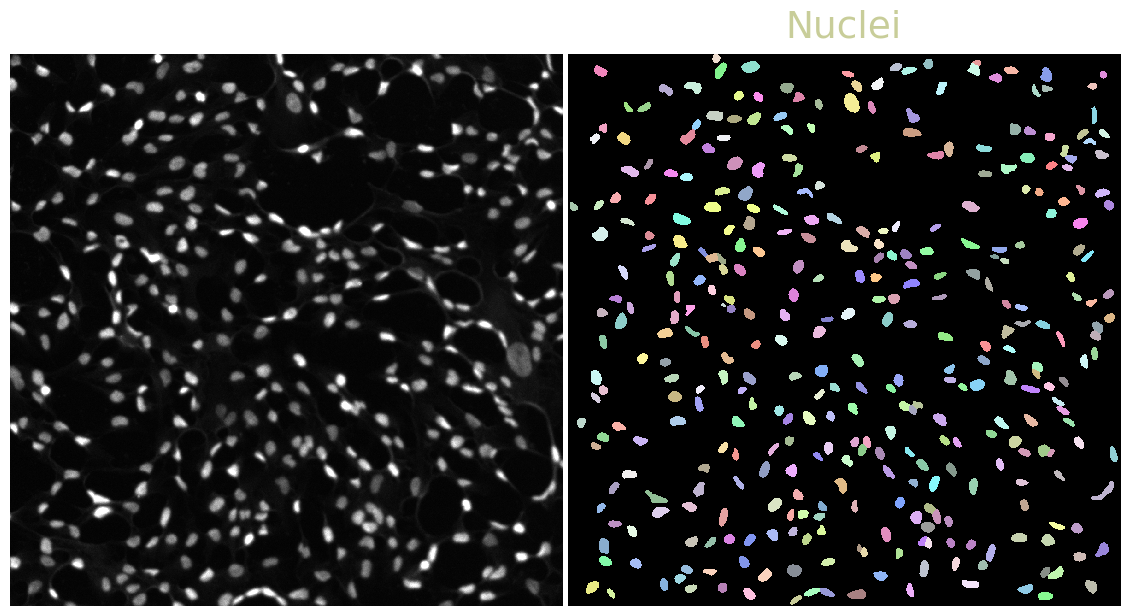

Example microplot for sequencing data annotated with segmentation:


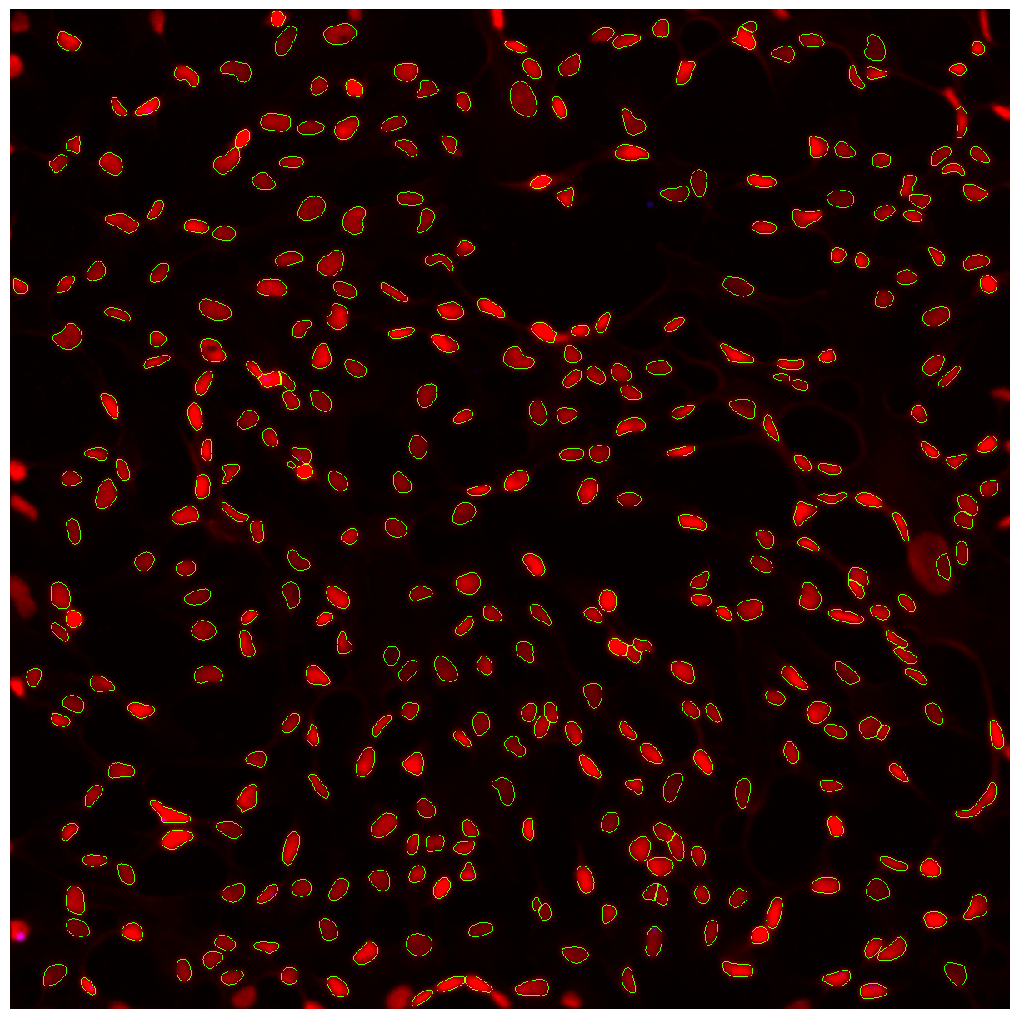

In [14]:
print(f"Segmenting image with {SEGMENTATION_METHOD}...")

if SEGMENTATION_METHOD == "cellpose":
    nuclei = segment_cellpose(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        nuclei_diameter=NUCLEI_DIAMETER,
        cell_diameter=CELL_DIAMETER,
        cellpose_kwargs=dict(
            nuclei_flow_threshold=NUCLEI_FLOW_THRESHOLD,
            nuclei_cellprob_threshold=NUCLEI_CELLPROB_THRESHOLD,
            cell_flow_threshold=CELL_FLOW_THRESHOLD,
            cell_cellprob_threshold=CELL_CELLPROB_THRESHOLD,
        ),
        cyto_model=CELLPOSE_MODEL,
        gpu=GPU,
        reconcile=RECONCILE,
        cells=SEGMENT_CELLS,
    )

elif SEGMENTATION_METHOD == "microsam":
    nuclei = segment_microsam(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=MICROSAM_MODEL,
        gpu=GPU,
        reconcile=RECONCILE,
        cells=SEGMENT_CELLS,
    )

elif SEGMENTATION_METHOD == "stardist":
    nuclei = segment_stardist(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=STARDIST_MODEL,
        stardist_kwargs=dict(
            nuclei_prob_threshold=NUCLEI_PROB_THRESHOLD,
            nuclei_nms_threshold=NUCLEI_NMS_THRESHOLD,
            cell_prob_threshold=CELL_PROB_THRESHOLD,
            cell_nms_threshold=CELL_NMS_THRESHOLD,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
        cells=SEGMENT_CELLS,
    )

elif SEGMENTATION_METHOD == "watershed":
    nuclei = segment_watershed(
        corrected_image,
        nuclei_threshold=THRESHOLD_DAPI,
        nuclei_area_min=NUCLEUS_AREA[0],
        nuclei_area_max=NUCLEUS_AREA[1],
        cell_threshold=THRESHOLD_CELL,
        cells=SEGMENT_CELLS,
    )

cells = np.zeros_like(nuclei)

# Create and display micropanel of nuclei segmention
print("Example microplots for DAPI channel and nuclei segmentation:")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_seg_microimages = [
    Microimage(cellpose_rgb[2], channel_names="Dapi"),
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
]
nuclei_seg_panel = create_micropanel(nuclei_seg_microimages, add_channel_label=True)
plt.show()

# # Create and display micropanel of segmented cells
# print("Example microplots for merged channels and cells segmentation:")
# cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
# cells_seg_microimages = [
#     Microimage(cellpose_rgb, channel_names="Merged"),
#     Microimage(cells, cmaps=cells_cmap, channel_names="Cells"),
# ]
# cells_seg_panel = create_micropanel(cells_seg_microimages, add_channel_label=True)
# plt.show()

# Create and display micropanel of annotated data
print("Example microplot for sequencing data annotated with segmentation:")
annotated_data = image_segmentation_annotations(cellpose_rgb[1:], nuclei, cells)
annotated_microimage = [
    Microimage(
        annotated_data,
        channel_names="Merged",
        cmaps=["pure_blue", "pure_red", "pure_green"],
    )
]
annotated_panel = create_micropanel(
    annotated_microimage, num_cols=1, figscaling=10, add_channel_label=False
)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Extract base intensity, call reads, assign to cells

- `DF_DESIGN_PATH`: The path to your guide RNA design file.
- `THRESHOLD_READS`: Initial threshold for detecting sequencing reads, set to 0 for preliminary analysis. This parameter will be optimized based on the mapping rate vs. peak threshold plot generated below. A higher threshold increases confidence in read calls but reduces the total number of detected reads.
- `CALL_READS_METHOD`: Method to use for correcting base intensity across channels. Options are:
    - `MEDIAN`: Uses median-based correction, performed independently for each tile. This is the default method.
    - `PERCENTILE`: Uses percentile-based correction, performed independently for each tile.

In [15]:
# Define parameters for extracting bases
DF_DESIGN_PATH = None
THRESHOLD_READS = None
CALL_READS_METHOD = "median"

In [16]:
# Read and format guide data
df_design = pd.read_csv(DF_DESIGN_PATH, sep="\t")
df_pool = df_design.query("dialout==[0,1]").drop_duplicates("sgRNA")
df_pool["prefix"] = df_pool.apply(lambda x: x.sgRNA[: x.prefix_length], axis=1)
barcodes = df_pool["prefix"]

# Run extract_bases and call_reads with the default threshold
df_bases = extract_bases(
    peaks, maxed, cells, THRESHOLD_READS, wildcards=WILDCARDS, bases=BASES
)
df_reads = call_reads(df_bases, peaks_data=peaks, method=CALL_READS_METHOD)

ValueError: Invalid file path or buffer object type: <class 'NoneType'>

The following plots will help determine the optimal `THRESHOLD_READS` value for your data:

In [ ]:
print("Mapping rate vs. peak threshold for determining optimal peak cutoff:")
plot_mapping_vs_threshold(df_reads, barcodes, "peak")
plt.show()

#### Left Plot (All Reads):
- Shows how the peak threshold affects all detected reads
- Blue line: Mapping rate (fraction of reads matching expected barcodes)
- Solid orange line: Total number of mapped spots (reads with valid barcodes)
- Dotted orange line: Number of unique cells with at least one mapped read

#### Right Plot (Cell-Associated Reads Only):
- Shows the same metrics but only for reads associated with cells

#### Setting Threshold Peaks:
Look for the point where the blue line (mapping rate) begins to plateau (~400)
- Consider the trade-off with number of mapped spots and cells
- A threshold around 300-500 typically provides a good balance:
  - Achieves ~75% mapping rate
  - Retains a reasonable number of mapped spots
  - Maintains coverage across cells

In [ ]:
THRESHOLD_READS = None

In [ ]:
# Re-run extract_bases and call_reads with the new threshold
print("Extracted bases:")
df_bases = extract_bases(
    peaks, maxed, cells, THRESHOLD_READS, wildcards=WILDCARDS, bases=BASES
)
display(df_bases)

print("Base intensity across cycles:")
ax = sns.pointplot(x="cycle", y="intensity", hue="channel", data=df_bases)
plt.show()

print("Intensity for each base:")
ax = sns.boxplot(
    x="channel", y="intensity", hue="channel", data=df_bases, showfliers=False
)
plt.show()

print("Called reads:")
df_reads = call_reads(df_bases, peaks_data=peaks)
display(df_reads)

## <font color='red'>SET PARAMETERS</font>

### Read mapping

- `BARCODE_COL`: Column name in df_pool containing barcode sequences.
- `ERROR_CORRECT`: Whether to correct reads by comparing each read to the set of available reads. If error correction is needed, further parameters such as `MAX_DISTANCE` and `DISTANCE_METRIC` can be defined.
- `Q_MIN`: The minimum quality score for each base read. Calculated as 1 - [log2(2 + second) / log2(2 + first)]. Default is 0 and typically remains unchanged. While the Q_min plot above shows the relationship between Q_min and mapping rate, adjusting THRESHOLD_READS is the preferred method for quality control. Higher Q_min values are more stringent but can excessively filter valid reads.

The following plots will help determine the optimal `Q_MIN` value for your data:

In [ ]:
print("Mapping rate vs. Q_min for determining optimal sequence quality cutoff:")
plot_mapping_vs_threshold(df_reads, barcodes, "Q_min")
plt.show()

#### Left Plot (All Reads):
- Shows how Q_min threshold affects all detected reads
- Blue line: Mapping rate (fraction of reads matching expected barcodes)
- Solid red line: Total number of mapped spots (reads with valid barcodes)
- Dotted red line: Number of unique cells with at least one mapped read

#### Right Plot (Cell-Associated Reads Only):
- Shows the same metrics but only for reads associated with cells

#### Interpreting Q_min Results:
With our optimized peak threshold, these plots confirm that adjusting Q_min provides little benefit:
- The mapping rate (blue line) is already very high at Q_min = 0
- Increasing Q_min only marginally improves mapping rate 
- However, this comes at a significant cost:
  - Total mapped spots and mapped cells decreases substantially
- The small gain in mapping rate doesn't justify the large loss of data

In [ ]:
# Define parameters for read mapping
BARCODE_COL = None
ERROR_CORRECT = False
Q_MIN = None

In [ ]:
print("Corrected cells:")
df_cells = call_cells(df_reads, df_pool=df_pool, q_min=Q_MIN, error_correct=ERROR_CORRECT)
display(df_cells)

print("Minimal phenotype features:")
df_sbs_info = extract_phenotype_minimal(
    phenotype_data=nuclei, nuclei_data=nuclei, wildcards=WILDCARDS
)
display(df_sbs_info)

print("Summary of the fraction of cells mapping to one barcode:")
one_barcode_mapping = plot_cell_mapping_heatmap(
    df_cells,
    df_sbs_info,
    barcodes,
    mapping_to="one",
    mapping_strategy="gene symbols",
    shape="6W_sbs",
    return_plot=False,
    return_summary=True,
)
display(one_barcode_mapping)

print("Summary of the fraction of cells mapping to any barcode:")
any_barcode_mapping = plot_cell_mapping_heatmap(
    df_cells,
    df_sbs_info,
    barcodes,
    mapping_to="any",
    mapping_strategy="gene symbols",
    shape="6W_sbs",
    return_plot=False,
    return_summary=True,
)
display(any_barcode_mapping)

print("Histogram of the number of reads per cell:")
outliers = plot_reads_per_cell_histogram(df_cells, x_cutoff=20)
plt.show()

print("Histogram of the number of counts of each unique gene symbols:")
outliers = plot_gene_symbol_histogram(df_cells, x_cutoff=30)
plt.show()

## Add sbs process parameters to config file

The `mode` parameter in the config file determines how Snakemake will execute parameter searches for segmentation optimization. Setting the `mode` to `segment_sbs_paramsearch` will systematically explore combinations of parameters for segmentation accuracy. This is not yet implemented.

In [16]:
# Add sbs section
config["sbs"] = {
    "alignment_method": ALIGNMENT_METHOD,
    "keep_extras": KEEP_EXTRAS,
    "max_filter_width": MAX_FILTER_WIDTH,
    "spot_detection_method": SPOT_DETECTION_METHOD,
    "segmentation_method": SEGMENTATION_METHOD,
    "segmentation_cycle_index": SEGMENTATION_CYCLE_INDEX,
    "segment_cells": SEGMENT_CELLS,
    "dapi_index": DAPI_INDEX,
    "cyto_index": CYTO_INDEX,
    "gpu": GPU,
    "reconcile": RECONCILE,
    # "df_design_path": DF_DESIGN_PATH,
    # "threshold_peaks": THRESHOLD_READS,
    # "bases": BASES,
    # "call_reads_method": CALL_READS_METHOD,
    # "barcode_col": BARCODE_COL,
    # "error_correct": ERROR_CORRECT,
    # "q_min": Q_MIN,
    "mode": None,
}

# Add spot detection method specific parameters
if SPOT_DETECTION_METHOD == "standard":
    config["sbs"].update({
        "peak_width": PEAK_WIDTH,
    })
elif SPOT_DETECTION_METHOD == "spotiflow":
    config["sbs"].update({
        "spotiflow_cycle_index": SPOTIFLOW_CYCLE_INDEX,
        "spotiflow_model": SPOTIFLOW_MODEL,
        "spotiflow_threshold": SPOTIFLOW_THRESHOLD,
        "spotiflow_min_distance": SPOTIFLOW_MIN_DISTANCE,
    })

# Add method-specific parameters based on segmentation method
if SEGMENTATION_METHOD == "cellpose":
    config["sbs"].update({
        "nuclei_diameter": NUCLEI_DIAMETER,
        "cell_diameter": CELL_DIAMETER,
        "nuclei_flow_threshold": NUCLEI_FLOW_THRESHOLD,
        "nuclei_cellprob_threshold": NUCLEI_CELLPROB_THRESHOLD,
        "cell_flow_threshold": CELL_FLOW_THRESHOLD,
        "cell_cellprob_threshold": CELL_CELLPROB_THRESHOLD,
        "cyto_model": CELLPOSE_MODEL,
    })
elif SEGMENTATION_METHOD == "microsam":
    config["sbs"].update({
        "microsam_model": MICROSAM_MODEL,
    })
elif SEGMENTATION_METHOD == "stardist":
    config["sbs"].update({
        "stardist_model": STARDIST_MODEL,
        "nuclei_prob_threshold": NUCLEI_PROB_THRESHOLD,
        "nuclei_nms_threshold": NUCLEI_NMS_THRESHOLD,
        "cell_prob_threshold": CELL_PROB_THRESHOLD,
        "cell_nms_threshold": CELL_NMS_THRESHOLD,
    })
elif SEGMENTATION_METHOD == "watershed":
    config["sbs"].update({
        "threshold_dapi": THRESHOLD_DAPI,
        "nucleus_area_min": NUCLEUS_AREA[0],
        "nucleus_area_max": NUCLEUS_AREA[1],
        "threshold_cell": THRESHOLD_CELL,
    })

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)